In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [32]:
# Taking in the subject data, each condition (see map) is the key for a
# blink value that is the number of blinks in the duration of the trial
npy_path = 'Subject1BlinksData.npy'
arr = np.load(npy_path, allow_pickle=True)
arr = arr.flat[0]

In [17]:
# Numerical map for each of the song and listening or imagining conditions
Listeningchor96_Indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Imaginingchor96_Indexes = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

Listeningchor38_Indexes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Imaginingchor38_Indexes = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

Listeningchor101_Indexes = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Imaginingchor101_Indexes = [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

Listeningchor19_Indexes = [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Imaginingchor19_Indexes = [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

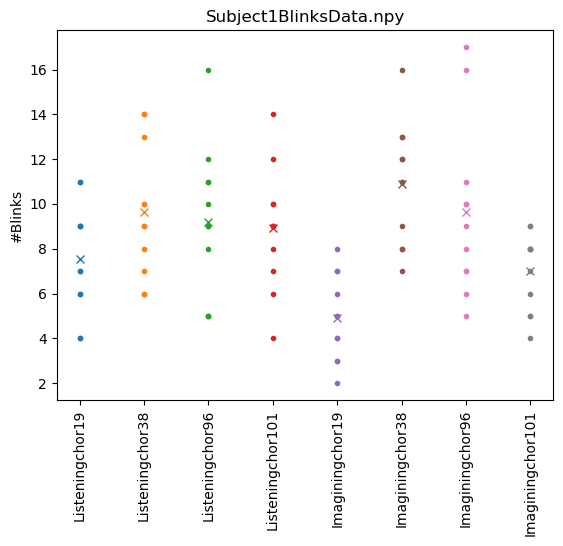

In [52]:
# Creating 2D array with rows equal to the number of chors and conditions and cols equal to test number
ConditionArray = np.empty([len(chors),len(chors[1])], dtype=int)

# Filling 2D ndarray with blink info row corresponds to L/I + chor##
# and col is the number of blinks in one of the 11 trials
rowi = 0
for chorindexes in chors:

    coli = 0
    for key in chorindexes:
        ConditionArray[rowi, coli] = arr[key]
        coli += 1

    rowi += 1


# Running statistical analysis with student's t. Comparing each condition to all others
# Array for storing the tstatistic and pval results as a list with [tstat, pval]
StatArray_t = np.empty([8,8], dtype = list)
StatArray_p = np.empty([8,8], dtype = list)

# Conducting two-tailed t test as the null hypothesis is that there is difference between the distributions
# Each distribution will be compared against all other distributions, including itself
rowi = 0
for Row in ConditionArray:
    trial, = plt.plot([rowi]*len(Row), Row, '.')
    plt.plot(rowi, np.mean(Row), 'x', c=trial.get_color())

    coli = 0
    for Col in ConditionArray:

        t_statistic, p_value = ttest_ind(Row, Col)
        
        StatArray_t[rowi, coli] = t_statistic
        StatArray_p[rowi, coli] = p_value
        coli += 1

    rowi += 1


# print(StatArray)


# Converting StatArray to a dataframe for easy analysis

df_t = pd.DataFrame(StatArray_t)
df_p = pd.DataFrame(StatArray_p)

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.ylabel('#Blinks')
plt.title(npy_path)
plt.show()

# Rename columns and rows for easy analysis
for df in [df_t, df_p]:
    df.rename(columns={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)

    df.rename(index={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)


    #print(df)

In [34]:
df_t

,Listeningchor19,Listeningchor38,Listeningchor96,Listeningchor101,Imaginingchor19,Imaginingchor38,Imaginingchor96,Imaginingchor101
Listeningchor19,0.0,-1.807051,-1.292325,-1.228024,2.79831,-3.051709,-1.515916,0.600601
Listeningchor38,1.807051,0.0,0.335276,0.6003,4.462245,-1.057093,0.0,2.561262
Listeningchor96,1.292325,-0.335276,0.0,0.207217,3.628289,-1.319317,-0.293307,1.896182
Listeningchor101,1.228024,-0.6003,-0.207217,0.0,3.967346,-1.725291,-0.510269,1.954863
Imaginingchor19,-2.79831,-4.462245,-3.628289,-3.967346,0.0,-6.004965,-3.640728,-2.680951
Imaginingchor38,3.051709,1.057093,1.319317,1.725291,6.004965,0.0,0.896994,4.041525
Imaginingchor96,1.515916,0.0,0.293307,0.510269,3.640728,-0.896994,0.0,2.069318
Imaginingchor101,-0.600601,-2.561262,-1.896182,-1.954863,2.680951,-4.041525,-2.069318,0.0


In [35]:
df_p

,Listeningchor19,Listeningchor38,Listeningchor96,Listeningchor101,Imaginingchor19,Imaginingchor38,Imaginingchor96,Imaginingchor101
Listeningchor19,1.0,0.085823,0.210977,0.233695,0.011098,0.006297,0.145187,0.554852
Listeningchor38,0.085823,1.0,0.740908,0.555048,0.000239,0.303071,1.0,0.01862
Listeningchor96,0.210977,0.740908,1.0,0.837936,0.001675,0.201969,0.772309,0.072477
Listeningchor101,0.233695,0.555048,0.837936,1.0,0.000759,0.099895,0.615449,0.064721
Imaginingchor19,0.011098,0.000239,0.001675,0.000759,1.0,0.000007,0.001627,0.014364
Imaginingchor38,0.006297,0.303071,0.201969,0.099895,0.000007,1.0,0.380393,0.000638
Imaginingchor96,0.145187,1.0,0.772309,0.615449,0.001627,0.380393,1.0,0.051685
Imaginingchor101,0.554852,0.01862,0.072477,0.064721,0.014364,0.000638,0.051685,1.0


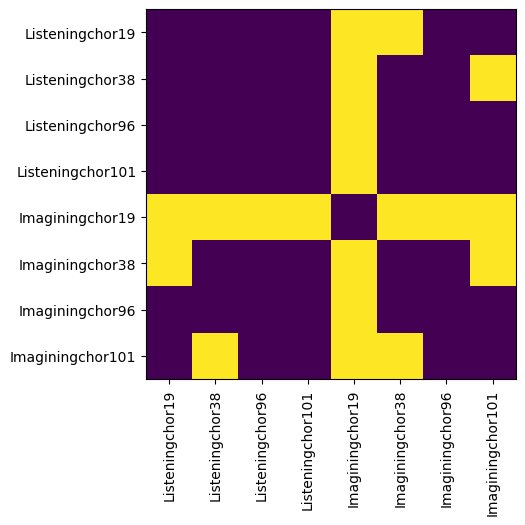

In [46]:
plt.imshow(np.array(df_p < 0.05))
plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.yticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    #rotation='vertical'
)
plt.show()